In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn import model_selection
from graphviz import Digraph

import numpy as np

# Урок 4. Алгоритм построения дерева решений

In [2]:
# Класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

    def __str__(self):
        return f'Признак: {self.index}\nПорог: {self.t:.2f}'
        
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [3]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [4]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [5]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [6]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

### 1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

#### Решение:

In [7]:
leaf_count = 0
level = 0

# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, leaf_limit=2 ** 32, level_limit=2 ** 32):
    global leaf_count, level
    
    quality, t, index = find_best_split(data, labels)    

    if quality == 0 or leaf_count + 1 == leaf_limit or level == level_limit or all(l == labels[0] for l in labels):        
        return Leaf(data, labels)
        
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    level += 1    
    
    leaf_count += 1   
    true_branch = build_tree(true_data, true_labels, leaf_limit, level_limit)    
    leaf_count += 1 
    false_branch = build_tree(false_data, false_labels, leaf_limit, level_limit)
    
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

#### Тестирование:

In [10]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

# Построим дерево по обучающей выборке
leaf_count = 0
level = 0
my_tree = build_tree(train_data, train_labels, 
                     leaf_limit=4, 
                     level_limit=3)

#### Проверка:

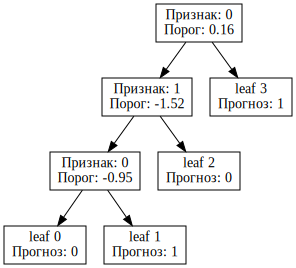

In [11]:
leaf_count = 0

# Напечатаем структуру нашего дерева
def print_tree(node, prev_node):
    global leaf_count
    
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        dot.node(f'leaf {leaf_count}', label=f'leaf {leaf_count}\nПрогноз: {node.prediction}')        
        dot.edge(str(prev_node.t), f'leaf {leaf_count}')
        leaf_count += 1
        return

    # Рекурсионный вызов функции на положительном поддереве
    dot.node(str(node.t), label=str(node))
    if prev_node is not None:
        dot.edge(str(prev_node.t), str(node.t))
        
    print_tree(node.true_branch, node)

    # Рекурсионный вызов функции на отрицательном поддереве
    dot.node(str(node.t), label=str(node))
    print_tree(node.false_branch, node)

dot = Digraph(node_attr={'shape': 'box'})    
print_tree(my_tree, None)   
dot  

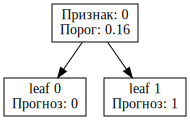

In [15]:
leaf_count = 0
level = 0
my_tree = build_tree(train_data, train_labels, 
                     leaf_limit=2, 
                     level_limit=3)

leaf_count = 0

dot = Digraph(node_attr={'shape': 'box'})    
print_tree(my_tree, None)   
dot  

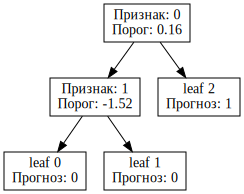

In [14]:
leaf_count = 0
level = 0
my_tree = build_tree(train_data, train_labels, 
                     leaf_limit=4, 
                     level_limit=2)

leaf_count = 0

dot = Digraph(node_attr={'shape': 'box'})    
print_tree(my_tree, None)   
dot  

### 2*.  Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [ ]:
# Класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        return np.mean(labels)

In [ ]:
# Расчет критерия Джини
def gini(labels):
    impurity = np.var(labels)
        
    return impurity